# Introdução ao Problema de Phishing e motivação do projeto
#### Integrantes do grupo: Gustavo Eliziario Stevenson de Oliveira, Pedro Gomes, Graziela Piacsek, Giovanna Sebba

Phishing é uma prática maliciosa em que fraudadadores criam páginas falsas, geralmente disfarçadas como websites legítimos, com o objetivo de roubar informações sensíveis, como senhas, dados bancários e outros tipos de credenciais. Esses ataques muitas vezes utilizam URLs enganosos que imitam endereços confiáveis para induzir os usuários a acreditar que estão acessando os sites autênticos.

O phishing é um problema de segunrança cibernética que impacta tanto indivíduos comuns quanto empresas, gerando perdas significativas e comprometendo a privacidade de usuários. Em nosso cenário no qual é inviável a inspeção manual de cada URL, surge a necessidade de métodos automatizados para a deteccção de phishing.

Por conta disso, o objetivo deste projeto é desenvolver um modelo preditivo capaz de classificar URLs como legítimos ou de phishing. Utilizando uma base de dados de URLs previamente rotulados, o modelo explorará características dos links para identificar padrões que diferencial URLs seguros de URLs maliciosos. Este modelo será desenvolvido no Databricks, permitindo que seu desemprenho seja escalável e que possa acessar grandes volumes de dados.


## Importar bibliotecas necessárias

Vamos importar as bibliotecas necessárias para o projeto

In [0]:
import pyspark.sql.functions as func

# Machine learning imports
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.classification import DecisionTreeClassifier
from pyspark.ml.classification import RandomForestClassifier, GBTClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.evaluation import BinaryClassificationEvaluator

# Mlflow
import mlflow
import mlflow.spark

from sklearn.metrics import roc_curve, auc, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

## Carregando tabelas

Para carregar tabelas, utilizaremos um caminho do S3:

In [0]:
# Recarregar o dataset com o cabeçalho correto
phishing_url = spark.read.csv("s3://bigdata-rais/projeto/gustavoeso/PhiUSIIL_Phishing_URL_Dataset.csv", header=True, inferSchema=True)

phishing_url.limit(5).display()

FILENAME,URL,URLLength,Domain,DomainLength,IsDomainIP,TLD,URLSimilarityIndex,CharContinuationRate,TLDLegitimateProb,URLCharProb,TLDLength,NoOfSubDomain,HasObfuscation,NoOfObfuscatedChar,ObfuscationRatio,NoOfLettersInURL,LetterRatioInURL,NoOfDegitsInURL,DegitRatioInURL,NoOfEqualsInURL,NoOfQMarkInURL,NoOfAmpersandInURL,NoOfOtherSpecialCharsInURL,SpacialCharRatioInURL,IsHTTPS,LineOfCode,LargestLineLength,HasTitle,Title,DomainTitleMatchScore,URLTitleMatchScore,HasFavicon,Robots,IsResponsive,NoOfURLRedirect,NoOfSelfRedirect,HasDescription,NoOfPopup,NoOfiFrame,HasExternalFormSubmit,HasSocialNet,HasSubmitButton,HasHiddenFields,HasPasswordField,Bank,Pay,Crypto,HasCopyrightInfo,NoOfImage,NoOfCSS,NoOfJS,NoOfSelfRef,NoOfEmptyRef,NoOfExternalRef,label
521848.txt,https://www.southbankmosaics.com,31,www.southbankmosaics.com,24,0,com,100,1,0.5229071,0.061933179,3,1,0,0,0,18,0.581,0,0,0,0,0,1,0.032,1,558,9381,1,à¸‚à¹ˆà¸²à¸§à¸ªà¸” à¸‚à¹ˆà¸²à¸§à¸§à¸±à¸™à¸™à¸µà¹‰ à¸‚à¹ˆà¸²à¸§à¸à¸µà¸¬à¸² à¸‚à¹ˆà¸²à¸§à¸šà¸±à¸™à¹€à¸—à¸´à¸‡ à¸­à¸±à¸žà¹€à¸”à¸—à¸ªà¸”à¹ƒà¸«à¸¡à¹ˆà¸—à¸¸à¸à¸§à¸±à¸™ – à¸‚à¹ˆà¸²à¸§à¸ªà¸” à¸‚à¹ˆà¸²à¸§à¸à¸µà¸¬à¸² à¸‚à¹ˆà¸²à¸§à¸šà¸±à¸™à¹€à¸—à¸´à¸‡ à¸‚à¹ˆà¸²à¸§à¸§à¸±à¸™à¸™à¸µà¹‰ à¸­à¸±à¸›à¹€à¸”à¸•à¸‚à¹ˆà¸²à¸§à¸ªà¸²à¸£à¸£à¸§à¸”à¹€à¸£à¹‡à¸§à¸—à¸±à¸™à¹ƒà¸ˆ à¸žà¸£à¹‰à¸­à¸¡à¸£à¸±à¸šà¸Šà¸¡à¸ªà¸²à¸£à¸°à¸™à¹ˆà¸²à¸£à¸¹à¹‰à¸•à¹ˆà¸²à¸‡à¹† à¹„à¸”à¹‰à¸Ÿà¸£à¸µà¸•à¸¥à¸­à¸” 24à¸Šà¸±à¹ˆà¸§à¹‚à¸¡à¸‡,0,0,0,1,1,0,0,0,0,1,0,0,1,1,0,1,0,0,1,34,20,28,119,0,124,1
31372.txt,https://www.uni-mainz.de,23,www.uni-mainz.de,16,0,de,100,0.666666667,0.0326503,0.050207214,2,1,0,0,0,9,0.391,0,0,0,0,0,2,0.087,1,618,9381,1,johannes gutenberg-universitÃ¤t mainz,55.55555556,55.55555556,1,1,0,0,0,0,0,0,0,1,1,0,0,0,0,0,1,50,9,8,39,0,217,1
597387.txt,https://www.voicefmradio.co.uk,29,www.voicefmradio.co.uk,22,0,uk,100,0.866666667,0.028555,0.06412872,2,2,0,0,0,15,0.517,0,0,0,0,0,2,0.069,1,467,682,1,voice fm southampton,46.66666667,46.66666667,0,1,1,0,0,1,0,0,0,0,1,1,0,0,0,0,1,10,2,7,42,2,5,1
554095.txt,https://www.sfnmjournal.com,26,www.sfnmjournal.com,19,0,com,100,1,0.5229071,0.057605756,3,1,0,0,0,13,0.5,0,0,0,0,0,1,0.038,1,6356,26824,1,home page: seminars in fetal and neonatal medicine,0,0,0,1,1,0,0,0,1,12,0,1,1,1,0,0,1,1,1,3,27,15,22,1,31,1
151578.txt,https://www.rewildingargentina.org,33,www.rewildingargentina.org,26,0,org,100,1,0.0799628,0.059441389,3,1,0,0,0,20,0.606,0,0,0,0,0,1,0.03,1,6089,28404,1,fundaciÃ³n rewilding argentina,100,100,0,1,1,1,1,1,0,2,0,1,1,1,0,1,1,0,1,244,15,34,72,1,85,1


Podemos exibir o DataFrame com o comando `display`

In [0]:
display(phishing_url.limit(2))

FILENAME,URL,URLLength,Domain,DomainLength,IsDomainIP,TLD,URLSimilarityIndex,CharContinuationRate,TLDLegitimateProb,URLCharProb,TLDLength,NoOfSubDomain,HasObfuscation,NoOfObfuscatedChar,ObfuscationRatio,NoOfLettersInURL,LetterRatioInURL,NoOfDegitsInURL,DegitRatioInURL,NoOfEqualsInURL,NoOfQMarkInURL,NoOfAmpersandInURL,NoOfOtherSpecialCharsInURL,SpacialCharRatioInURL,IsHTTPS,LineOfCode,LargestLineLength,HasTitle,Title,DomainTitleMatchScore,URLTitleMatchScore,HasFavicon,Robots,IsResponsive,NoOfURLRedirect,NoOfSelfRedirect,HasDescription,NoOfPopup,NoOfiFrame,HasExternalFormSubmit,HasSocialNet,HasSubmitButton,HasHiddenFields,HasPasswordField,Bank,Pay,Crypto,HasCopyrightInfo,NoOfImage,NoOfCSS,NoOfJS,NoOfSelfRef,NoOfEmptyRef,NoOfExternalRef,label
521848.txt,https://www.southbankmosaics.com,31,www.southbankmosaics.com,24,0,com,100,1,0.5229071,0.061933179,3,1,0,0,0,18,0.581,0,0,0,0,0,1,0.032,1,558,9381,1,à¸‚à¹ˆà¸²à¸§à¸ªà¸” à¸‚à¹ˆà¸²à¸§à¸§à¸±à¸™à¸™à¸µà¹‰ à¸‚à¹ˆà¸²à¸§à¸à¸µà¸¬à¸² à¸‚à¹ˆà¸²à¸§à¸šà¸±à¸™à¹€à¸—à¸´à¸‡ à¸­à¸±à¸žà¹€à¸”à¸—à¸ªà¸”à¹ƒà¸«à¸¡à¹ˆà¸—à¸¸à¸à¸§à¸±à¸™ – à¸‚à¹ˆà¸²à¸§à¸ªà¸” à¸‚à¹ˆà¸²à¸§à¸à¸µà¸¬à¸² à¸‚à¹ˆà¸²à¸§à¸šà¸±à¸™à¹€à¸—à¸´à¸‡ à¸‚à¹ˆà¸²à¸§à¸§à¸±à¸™à¸™à¸µà¹‰ à¸­à¸±à¸›à¹€à¸”à¸•à¸‚à¹ˆà¸²à¸§à¸ªà¸²à¸£à¸£à¸§à¸”à¹€à¸£à¹‡à¸§à¸—à¸±à¸™à¹ƒà¸ˆ à¸žà¸£à¹‰à¸­à¸¡à¸£à¸±à¸šà¸Šà¸¡à¸ªà¸²à¸£à¸°à¸™à¹ˆà¸²à¸£à¸¹à¹‰à¸•à¹ˆà¸²à¸‡à¹† à¹„à¸”à¹‰à¸Ÿà¸£à¸µà¸•à¸¥à¸­à¸” 24à¸Šà¸±à¹ˆà¸§à¹‚à¸¡à¸‡,0,0,0,1,1,0,0,0,0,1,0,0,1,1,0,1,0,0,1,34,20,28,119,0,124,1
31372.txt,https://www.uni-mainz.de,23,www.uni-mainz.de,16,0,de,100,0.666666667,0.0326503,0.050207214,2,1,0,0,0,9,0.391,0,0,0,0,0,2,0.087,1,618,9381,1,johannes gutenberg-universitÃ¤t mainz,55.55555556,55.55555556,1,1,0,0,0,0,0,0,0,1,1,0,0,0,0,0,1,50,9,8,39,0,217,1


In [0]:
phishing_url.limit(3).display()

FILENAME,URL,URLLength,Domain,DomainLength,IsDomainIP,TLD,URLSimilarityIndex,CharContinuationRate,TLDLegitimateProb,URLCharProb,TLDLength,NoOfSubDomain,HasObfuscation,NoOfObfuscatedChar,ObfuscationRatio,NoOfLettersInURL,LetterRatioInURL,NoOfDegitsInURL,DegitRatioInURL,NoOfEqualsInURL,NoOfQMarkInURL,NoOfAmpersandInURL,NoOfOtherSpecialCharsInURL,SpacialCharRatioInURL,IsHTTPS,LineOfCode,LargestLineLength,HasTitle,Title,DomainTitleMatchScore,URLTitleMatchScore,HasFavicon,Robots,IsResponsive,NoOfURLRedirect,NoOfSelfRedirect,HasDescription,NoOfPopup,NoOfiFrame,HasExternalFormSubmit,HasSocialNet,HasSubmitButton,HasHiddenFields,HasPasswordField,Bank,Pay,Crypto,HasCopyrightInfo,NoOfImage,NoOfCSS,NoOfJS,NoOfSelfRef,NoOfEmptyRef,NoOfExternalRef,label
521848.txt,https://www.southbankmosaics.com,31,www.southbankmosaics.com,24,0,com,100,1,0.5229071,0.061933179,3,1,0,0,0,18,0.581,0,0,0,0,0,1,0.032,1,558,9381,1,à¸‚à¹ˆà¸²à¸§à¸ªà¸” à¸‚à¹ˆà¸²à¸§à¸§à¸±à¸™à¸™à¸µà¹‰ à¸‚à¹ˆà¸²à¸§à¸à¸µà¸¬à¸² à¸‚à¹ˆà¸²à¸§à¸šà¸±à¸™à¹€à¸—à¸´à¸‡ à¸­à¸±à¸žà¹€à¸”à¸—à¸ªà¸”à¹ƒà¸«à¸¡à¹ˆà¸—à¸¸à¸à¸§à¸±à¸™ – à¸‚à¹ˆà¸²à¸§à¸ªà¸” à¸‚à¹ˆà¸²à¸§à¸à¸µà¸¬à¸² à¸‚à¹ˆà¸²à¸§à¸šà¸±à¸™à¹€à¸—à¸´à¸‡ à¸‚à¹ˆà¸²à¸§à¸§à¸±à¸™à¸™à¸µà¹‰ à¸­à¸±à¸›à¹€à¸”à¸•à¸‚à¹ˆà¸²à¸§à¸ªà¸²à¸£à¸£à¸§à¸”à¹€à¸£à¹‡à¸§à¸—à¸±à¸™à¹ƒà¸ˆ à¸žà¸£à¹‰à¸­à¸¡à¸£à¸±à¸šà¸Šà¸¡à¸ªà¸²à¸£à¸°à¸™à¹ˆà¸²à¸£à¸¹à¹‰à¸•à¹ˆà¸²à¸‡à¹† à¹„à¸”à¹‰à¸Ÿà¸£à¸µà¸•à¸¥à¸­à¸” 24à¸Šà¸±à¹ˆà¸§à¹‚à¸¡à¸‡,0,0,0,1,1,0,0,0,0,1,0,0,1,1,0,1,0,0,1,34,20,28,119,0,124,1
31372.txt,https://www.uni-mainz.de,23,www.uni-mainz.de,16,0,de,100,0.666666667,0.0326503,0.050207214,2,1,0,0,0,9,0.391,0,0,0,0,0,2,0.087,1,618,9381,1,johannes gutenberg-universitÃ¤t mainz,55.55555556,55.55555556,1,1,0,0,0,0,0,0,0,1,1,0,0,0,0,0,1,50,9,8,39,0,217,1
597387.txt,https://www.voicefmradio.co.uk,29,www.voicefmradio.co.uk,22,0,uk,100,0.866666667,0.028555,0.06412872,2,2,0,0,0,15,0.517,0,0,0,0,0,2,0.069,1,467,682,1,voice fm southampton,46.66666667,46.66666667,0,1,1,0,0,1,0,0,0,0,1,1,0,0,0,0,1,10,2,7,42,2,5,1


## Exibindo o esquema dos dados

Ao realizarmos a ingestão da tabela de receitas, cada variável disponível na tabela foi configurada com um tipo de dados (inteiro, texto, ponto flutuante, etc). Podemos conferir o tipo de cada coluna com o comando `df.printSchema()`

In [0]:
phishing_url.printSchema()

root
 |-- FILENAME: string (nullable = true)
 |-- URL: string (nullable = true)
 |-- URLLength: integer (nullable = true)
 |-- Domain: string (nullable = true)
 |-- DomainLength: integer (nullable = true)
 |-- IsDomainIP: integer (nullable = true)
 |-- TLD: string (nullable = true)
 |-- URLSimilarityIndex: double (nullable = true)
 |-- CharContinuationRate: double (nullable = true)
 |-- TLDLegitimateProb: double (nullable = true)
 |-- URLCharProb: double (nullable = true)
 |-- TLDLength: integer (nullable = true)
 |-- NoOfSubDomain: integer (nullable = true)
 |-- HasObfuscation: integer (nullable = true)
 |-- NoOfObfuscatedChar: integer (nullable = true)
 |-- ObfuscationRatio: double (nullable = true)
 |-- NoOfLettersInURL: integer (nullable = true)
 |-- LetterRatioInURL: double (nullable = true)
 |-- NoOfDegitsInURL: integer (nullable = true)
 |-- DegitRatioInURL: double (nullable = true)
 |-- NoOfEqualsInURL: integer (nullable = true)
 |-- NoOfQMarkInURL: integer (nullable = true)
 |

## Análise Exploratória da base de dados

Nesta etapa da análise exploratória, buscamos entender as características dos dados que compõe nossa amostra de URLs rotulados. A análise exploratória é importante para identificar padrões, tendências e possíveis correlações entre as variáveis, permitindo que possamos melhorar nossa estratégia de modelagem. Exploraremos a distribuição de características que julgamos importantes, como o comprimento das URLs e dos domínios, a taxa de continuidade de caracteres e a probabilidade de legitimidade dos Top-Level Domains. 

In [0]:
print("{} linhas e {} colunas".format(phishing_url.count(), len(phishing_url.columns)))

235795 linhas e 56 colunas


In [0]:
# Remover a coluna FILENAME e escolher apenas as features e o label
selected_columns = ["URLLength", "DomainLength", "CharContinuationRate", "TLDLegitimateProb", "label"]

# Criar um novo DataFrame com as colunas selecionadas
phishing_data_cleaned = phishing_url.select(selected_columns)

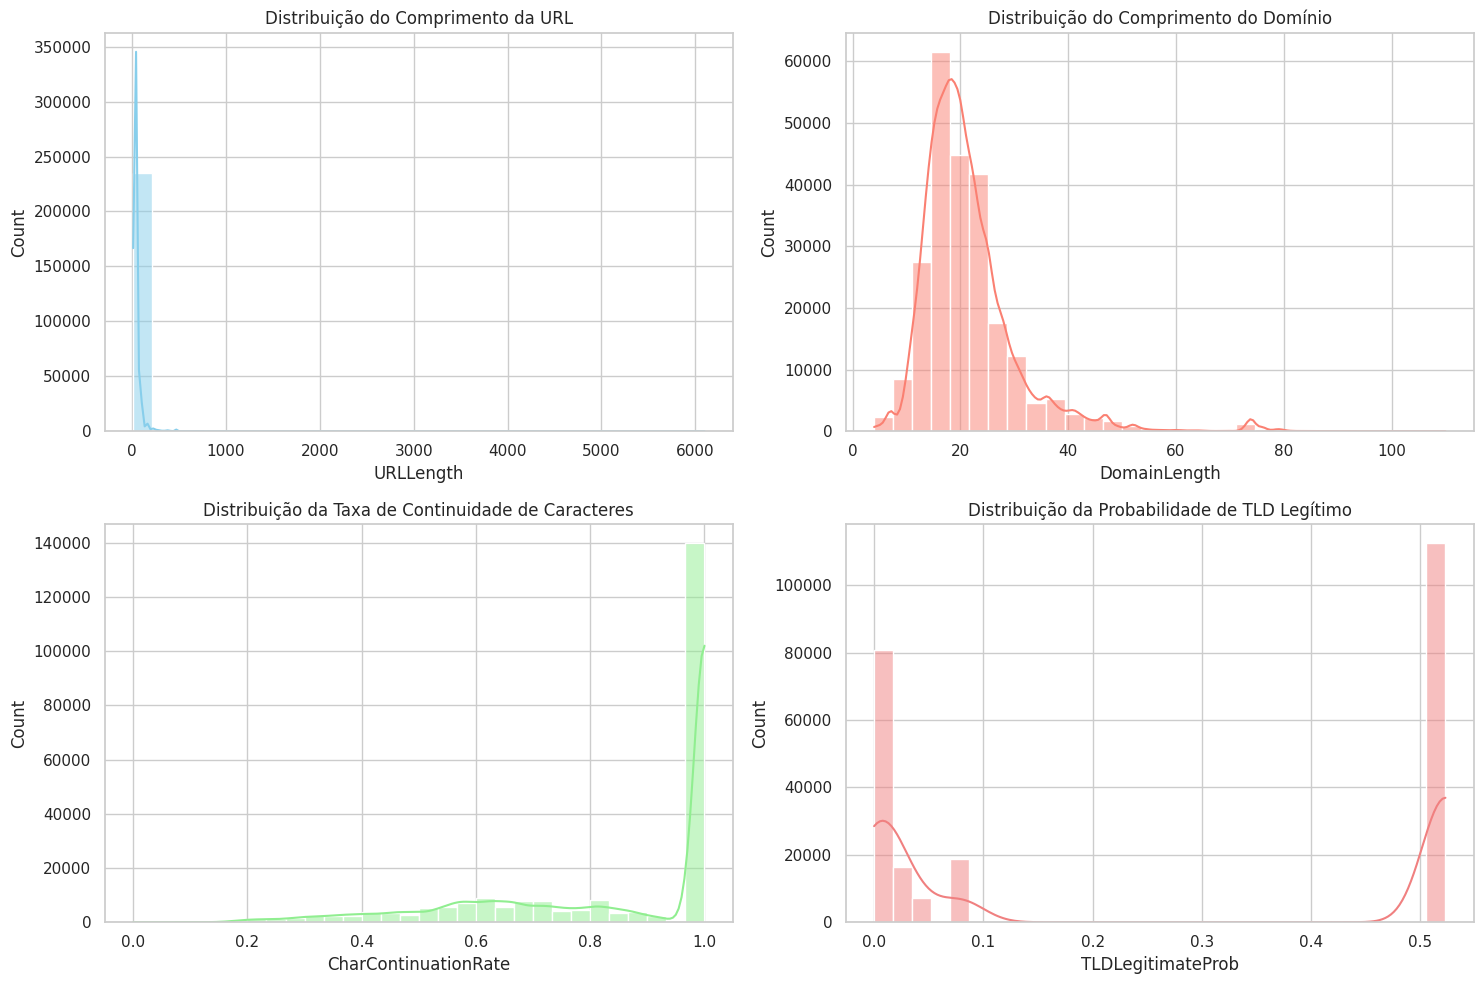

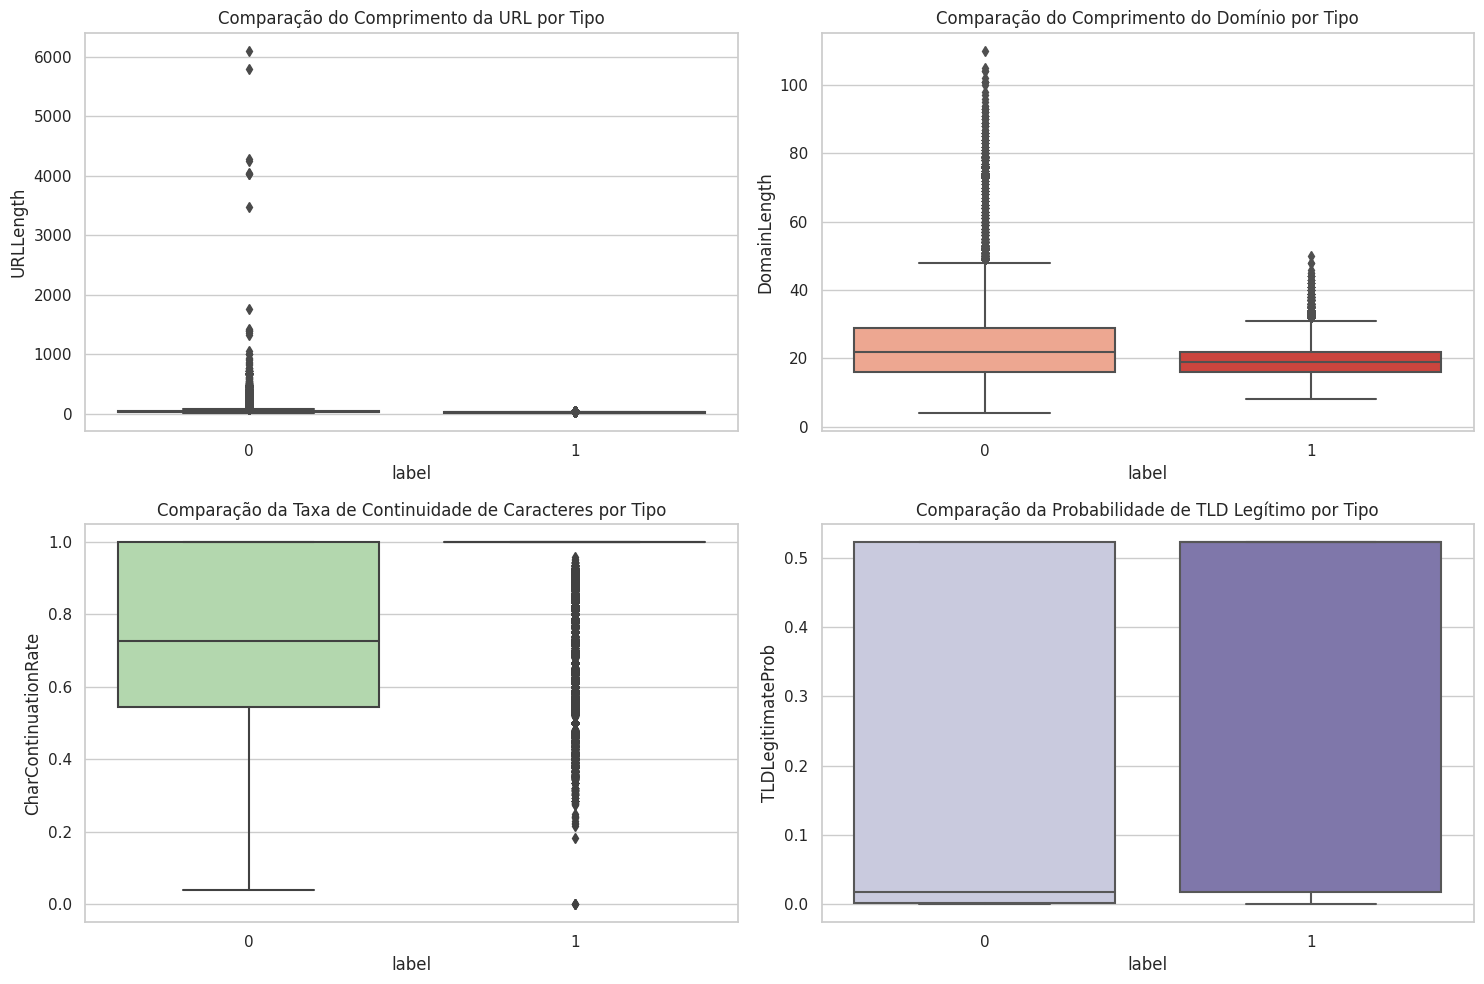

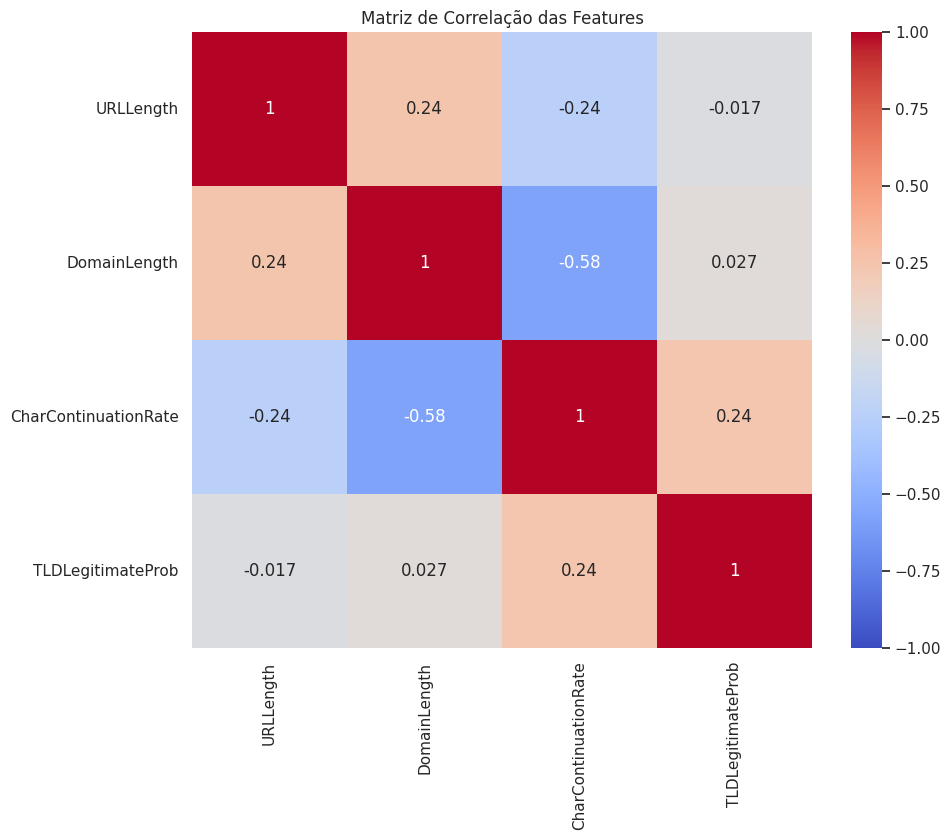

In [0]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Converter o Spark DataFrame para Pandas DataFrame para análise exploratória
phishing_df = phishing_data_cleaned.toPandas()

# Configurar o estilo do seaborn para os gráficos
sns.set(style="whitegrid")

# 1. Histogramas para observar a distribuição das features
plt.figure(figsize=(15, 10))
plt.subplot(2, 2, 1)
sns.histplot(phishing_df['URLLength'], kde=True, bins=30, color="skyblue")
plt.title("Distribuição do Comprimento da URL")

plt.subplot(2, 2, 2)
sns.histplot(phishing_df['DomainLength'], kde=True, bins=30, color="salmon")
plt.title("Distribuição do Comprimento do Domínio")

plt.subplot(2, 2, 3)
sns.histplot(phishing_df['CharContinuationRate'], kde=True, bins=30, color="lightgreen")
plt.title("Distribuição da Taxa de Continuidade de Caracteres")

plt.subplot(2, 2, 4)
sns.histplot(phishing_df['TLDLegitimateProb'], kde=True, bins=30, color="lightcoral")
plt.title("Distribuição da Probabilidade de TLD Legítimo")
plt.tight_layout()
plt.show()

# 2. Boxplots para comparar URLs legítimas e phishing para cada feature
plt.figure(figsize=(15, 10))
plt.subplot(2, 2, 1)
sns.boxplot(x='label', y='URLLength', data=phishing_df, palette="Blues")
plt.title("Comparação do Comprimento da URL por Tipo")

plt.subplot(2, 2, 2)
sns.boxplot(x='label', y='DomainLength', data=phishing_df, palette="Reds")
plt.title("Comparação do Comprimento do Domínio por Tipo")

plt.subplot(2, 2, 3)
sns.boxplot(x='label', y='CharContinuationRate', data=phishing_df, palette="Greens")
plt.title("Comparação da Taxa de Continuidade de Caracteres por Tipo")

plt.subplot(2, 2, 4)
sns.boxplot(x='label', y='TLDLegitimateProb', data=phishing_df, palette="Purples")
plt.title("Comparação da Probabilidade de TLD Legítimo por Tipo")
plt.tight_layout()
plt.show()

# 3. Matriz de Correlação entre as Features
plt.figure(figsize=(10, 8))
correlation = phishing_df[['URLLength', 'DomainLength', 'CharContinuationRate', 'TLDLegitimateProb']].corr()
sns.heatmap(correlation, annot=True, cmap="coolwarm", vmin=-1, vmax=1)
plt.title("Matriz de Correlação das Features")
plt.show()


# Com base nos gráficos gerados, podemos observar diferentes aspectos das variáveis em nosso conjunto de dados:

### 1. Distribuição das Features Individuais:

- **Comprimento da URL:** A maioria das URLs tem comprimento relativamente curto, mas existem outliers com comprimentos significativamente maiores. 

- **Comprimento do Domínio:** Observamos que a maior parte dos domínios tem um comprimento médio, com uma queda acentuada conforme o comprimento aumenta. 

- **Taxa de Continuidade de Caracteres:** A taxa de continuidade de caracteres representa a frequência de padrões sequenciais na URL. 

- **Probabilidade de TLD Legítimo:** Esta métrica indica a probabilidade do TLD ser associado a domínios legítimos. 

### 2. Comparação das Features entre URLs Legítimos e de Phishing. Os gráficos de boxplot comparam URLs legítimos e de phishing em relação a cada feature:

- **Comprimento da URL:** URLs de phishing tendem a ser mais longas, enquanto URLs legítimas permanecem em um intervalo mais curto.

- **Comprimento do Domínio:** Domínios de phishing apresentam uma maior variação no comprimento em comparação com domínios legítimos.

- **Taxa de Continuidade de Caracteres:** URLs de phishing apresentam uma taxa de continuidade de caracteres visivelmente mais alta, sugerindo que essa característica pode ser um indicador importante na detecção de phishing.

- **Probabilidade de TLD Legítimo:** URLs legítimas possuem uma probabilidade mais alta de TLD legítimo, indicando que essa feature pode ajudar na identificação de domínios suspeitos.

### 3. Matriz de Correlação das Features. A matriz de correlação revela a relação entre as variáveis do conjunto de dados:

- **URLLength** e **DomainLength** têm uma correlação moderada positiva, sugerindo que URLs mais longas tendem a ter domínios mais longos.

- **CharContinuationRat** e **DomainLength** apresentam uma correlação negativa, indicando que domínios mais longos têm menos continuidade de caracteres.

- **TLDLegitimateProb** tem baixa correlação com outras variáveis, o que significa que essa feature pode trazer informações exclusivas e complementares ao modelo.

## Passo 1: Preparação dos Dados e Seleção das Features

In [0]:
# Selecionar as colunas necessárias
# Remover a coluna FILENAME e escolher apenas as features e o label
selected_columns = ["URLLength", "DomainLength", "CharContinuationRate", "TLDLegitimateProb", "label"]

# Criar um novo DataFrame com as colunas selecionadas
phishing_data_cleaned = phishing_url.select(selected_columns)

# Exibir algumas linhas para ver o estado atual dos dados
phishing_data_cleaned.show(5)


+---------+------------+--------------------+-----------------+-----+
|URLLength|DomainLength|CharContinuationRate|TLDLegitimateProb|label|
+---------+------------+--------------------+-----------------+-----+
|       31|          24|                 1.0|        0.5229071|    1|
|       23|          16|         0.666666667|        0.0326503|    1|
|       29|          22|         0.866666667|         0.028555|    1|
|       26|          19|                 1.0|        0.5229071|    1|
|       33|          26|                 1.0|        0.0799628|    1|
+---------+------------+--------------------+-----------------+-----+
only showing top 5 rows



## Passo 2: Montar o Vetor de Features

In [0]:
# Lista das features a serem combinadas no vetor
feature_cols = ["URLLength", "DomainLength", "CharContinuationRate", "TLDLegitimateProb"]

# Configurar o VectorAssembler para transformar as features em uma coluna de vetor chamada "features"
assembler = VectorAssembler(inputCols=feature_cols, outputCol="features")

# Aplicar o assembler aos dados
phishing_data_final = assembler.transform(phishing_data_cleaned)

# Exibir as primeiras linhas para ver como ficou a coluna "features"
phishing_data_final.select("features", "label").show(5)


+--------------------+-----+
|            features|label|
+--------------------+-----+
|[31.0,24.0,1.0,0....|    1|
|[23.0,16.0,0.6666...|    1|
|[29.0,22.0,0.8666...|    1|
|[26.0,19.0,1.0,0....|    1|
|[33.0,26.0,1.0,0....|    1|
+--------------------+-----+
only showing top 5 rows



## Passo 3: Dividir os Dados em Conjuntos de Treino e Teste

In [0]:
# Dividir os dados em 80% para treino e 20% para teste (caso ainda não tenha rodado antes)
train_data, test_data = phishing_data_final.randomSplit([0.8, 0.2], seed=42)

# Iniciar um experimento com MLflow
with mlflow.start_run():
    # Registrar a divisão de dados como um parâmetro no MLflow
    mlflow.log_param("train_test_split", "80/20")
    
    # Configurar e treinar o modelo de Regressão Logística
    lr = LogisticRegression(featuresCol="features", labelCol="label")
    lr_model = lr.fit(train_data)
    mlflow.spark.log_model(lr_model, "logistic_regression_model")
    
    # Configurar e treinar o modelo de Árvore de Decisão
    dt = DecisionTreeClassifier(featuresCol="features", labelCol="label")
    dt_model = dt.fit(train_data)
    mlflow.spark.log_model(dt_model, "decision_tree_model")
    
    print("Modelos de Regressão Logística e Árvore de Decisão treinados e registrados com MLflow")


2024/10/31 20:02:11 INFO mlflow.spark: Inferring pip requirements by reloading the logged model from the databricks artifact repository, which can be time-consuming. To speed up, explicitly specify the conda_env or pip_requirements when calling log_model().
2024/10/31 20:03:06 WARNING mlflow.utils.environment: Encountered an unexpected error while inferring pip requirements (model URI: dbfs:/databricks/mlflow-tracking/729780563443402/b1d2c2740a3246a5808ca37badd4100e/artifacts/logistic_regression_model/sparkml, flavor: spark). Fall back to return ['pyspark==3.5.0']. Set logging level to DEBUG to see the full traceback. 
/databricks/python/lib/python3.11/site-packages/_distutils_hack/__init__.py:33: UserWarning: Setuptools is replacing distutils.
  warnings.warn("Setuptools is replacing distutils.")
2024/10/31 20:03:43 INFO mlflow.spark: Inferring pip requirements by reloading the logged model from the databricks artifact repository, which can be time-consuming. To speed up, explicitly s

Modelos de Regressão Logística e Árvore de Decisão treinados e registrados com MLflow


## Passo 4: Avaliação dos Modelos

In [0]:
# Configurar o avaliador para o problema de classificação binária com a métrica areaUnderROC
evaluator = BinaryClassificationEvaluator(labelCol="label", rawPredictionCol="rawPrediction", metricName="areaUnderROC")

# Avaliar o modelo de Regressão Logística
lr_predictions = lr_model.transform(test_data)
lr_auc = evaluator.evaluate(lr_predictions)
mlflow.log_metric("logistic_regression_auc", lr_auc)
print(f"AUC do modelo de Regressão Logística: {lr_auc}")

# Avaliar o modelo de Árvore de Decisão
dt_predictions = dt_model.transform(test_data)
dt_auc = evaluator.evaluate(dt_predictions)
mlflow.log_metric("decision_tree_auc", dt_auc)
print(f"AUC do modelo de Árvore de Decisão: {dt_auc}")

# Fim da execução no MLflow
mlflow.end_run()


AUC do modelo de Regressão Logística: 0.7668067581259318
AUC do modelo de Árvore de Decisão: 0.8378759302420158


## Passo 4.1: Avaliando mais modelos

#### incluindo:
1. Random Forest
2. Gradient-Boosted Trees (GBT)

In [0]:
# Iniciar um novo experimento com MLflow
with mlflow.start_run():
    # Random Forest
    rf = RandomForestClassifier(featuresCol="features", labelCol="label", numTrees=100)
    rf_model = rf.fit(train_data)
    rf_predictions = rf_model.transform(test_data)
    rf_auc = evaluator.evaluate(rf_predictions)
    mlflow.log_metric("random_forest_auc", rf_auc)
    mlflow.spark.log_model(rf_model, "random_forest_model")
    print(f"AUC do modelo Random Forest: {rf_auc}")
    
    # Gradient-Boosted Trees
    gbt = GBTClassifier(featuresCol="features", labelCol="label", maxIter=100)
    gbt_model = gbt.fit(train_data)
    gbt_predictions = gbt_model.transform(test_data)
    gbt_auc = evaluator.evaluate(gbt_predictions)
    mlflow.log_metric("gradient_boosted_trees_auc", gbt_auc)
    mlflow.spark.log_model(gbt_model, "gradient_boosted_trees_model")
    print(f"AUC do modelo Gradient-Boosted Trees: {gbt_auc}")

# Fim da execução do MLflow
mlflow.end_run()


2024/10/31 20:05:31 INFO mlflow.spark: Inferring pip requirements by reloading the logged model from the databricks artifact repository, which can be time-consuming. To speed up, explicitly specify the conda_env or pip_requirements when calling log_model().
2024/10/31 20:06:11 WARNING mlflow.utils.environment: Encountered an unexpected error while inferring pip requirements (model URI: dbfs:/databricks/mlflow-tracking/729780563443402/2a1112f8c4b84637a0646acc0563b652/artifacts/random_forest_model/sparkml, flavor: spark). Fall back to return ['pyspark==3.5.0']. Set logging level to DEBUG to see the full traceback. 


AUC do modelo Random Forest: 0.8831511550147081


2024/10/31 20:09:04 INFO mlflow.spark: Inferring pip requirements by reloading the logged model from the databricks artifact repository, which can be time-consuming. To speed up, explicitly specify the conda_env or pip_requirements when calling log_model().
2024/10/31 20:09:45 WARNING mlflow.utils.environment: Encountered an unexpected error while inferring pip requirements (model URI: dbfs:/databricks/mlflow-tracking/729780563443402/2a1112f8c4b84637a0646acc0563b652/artifacts/gradient_boosted_trees_model/sparkml, flavor: spark). Fall back to return ['pyspark==3.5.0']. Set logging level to DEBUG to see the full traceback. 


AUC do modelo Gradient-Boosted Trees: 0.9696015209295391


## Passo 4.2: Gráficos de desempenho

### Curva ROC

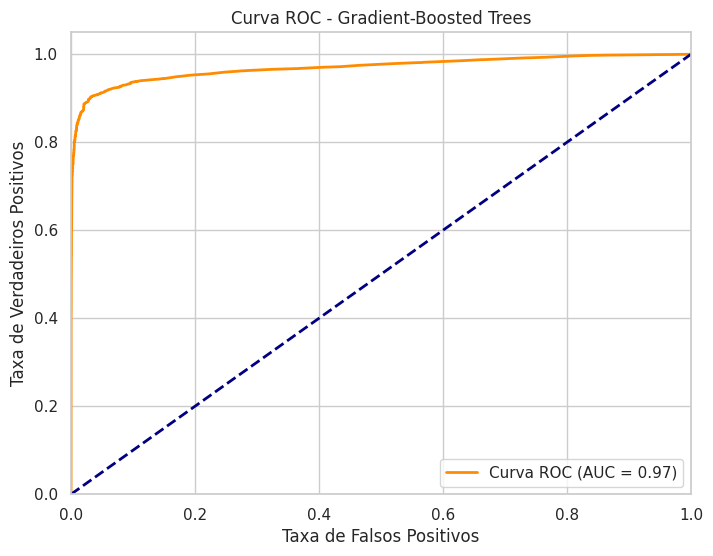

In [0]:
# Converter as previsões do GBT para um DataFrame Pandas
gbt_predictions_pd = gbt_predictions.select("label", "probability").toPandas()

# Extrair as probabilidades para a classe phishing (índice [0] da probabilidade)
y_true = gbt_predictions_pd["label"]
y_score = gbt_predictions_pd["probability"].apply(lambda x: x[0])

# Calcular a curva ROC e a AUC
fpr, tpr, _ = roc_curve(y_true, y_score, pos_label=0)
roc_auc = auc(fpr, tpr)

# Plotar a Curva ROC
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color="darkorange", lw=2, label=f"Curva ROC (AUC = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], color="navy", lw=2, linestyle="--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("Taxa de Falsos Positivos")
plt.ylabel("Taxa de Verdadeiros Positivos")
plt.title("Curva ROC - Gradient-Boosted Trees")
plt.legend(loc="lower right")
plt.show()

### Matriz de confusão

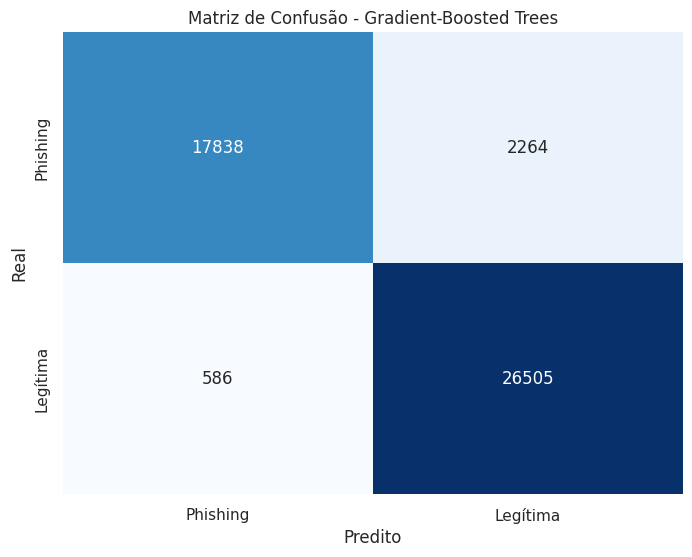

In [0]:
# Gerar a matriz de confusão
y_pred = gbt_predictions_pd["probability"].apply(lambda x: 0 if x[0] > 0.5 else 1)
conf_matrix = confusion_matrix(y_true, y_pred)

# Plotar a Matriz de Confusão
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", cbar=False,
            xticklabels=["Phishing", "Legítima"], yticklabels=["Phishing", "Legítima"])
plt.xlabel("Predito")
plt.ylabel("Real")
plt.title("Matriz de Confusão - Gradient-Boosted Trees")
plt.show()

# Análise dos resultados do modelo

1. **Curva ROC (AUC = 0,97):**
    
    A Curva ROC (Receiver Operating Characteristic) é uma ferramenta que ilustra o desempenho do modelo em relação a sua capacidade de diferenciar entre classes positivas e negativas, neste caso, URLs de phishing e legítimos. A área sob a curva (AUC) é um indicador chave: quanto mais próximo de 1, melhor o desempenho do modelo.

    Com uma AUC de 0,97, o modelo Gradient-Boosted Trees (GBT) demonstra uma alta eficiência em classificar URLs como phishing ou legítimos. A curva que se aproxima do canto superior esquerdo reforça que o modelo tem uma taxa alta de verdadeiros positivos e uma baixa taxa de falsos positivos, confirmando sua capacidade de diferenciação e minimizando os erros.

2. **Matriz de Confusão:**

    A matriz de confusão permite visualizar o número de previsões corretas e incorretas realizadas pelo modelo. Os valores são divididos entre verdadeiros positivos (URLs de phishing corretamente classificados), falsos negativos (URLs de phishing não detectados), verdadeiros negativos (URLs legítimos corretamente identificados) e falsos positivos (URLs legítimos classificados incorretamente como phishing).

    - Verdadeiros Positivos (Phishing Detectados): 17.838 URLs, quantidade significativa de detecções corretas de URLs maliciosos.

    - Falsos Negativos (Phishing Não Detectado): 2.264 URLs, número relativamente baixo de URLs de phishing que passaram despercebidos.

    - Verdadeiros Negativos (Legítima Detectada): 26.505 URLs, demonstrando uma forte capacidade do modelo em reconhecer URLs legítimos.

    - Falsos Positivos (Legítima Classificada como Phishing): 586 URLs, valor baixo que indica que o modelo não está gerando muitos alertas falsos para URLs legítimos.

A matriz de confusão mostra que o modelo possui uma taxa baixa tanto de falsos positivos quanto de falsos negativos, o que sugere que ele é eficiente em identificar corretamente tanto URLs de phishing quanto URLs legítimos. Esse desempenho balanceado indica que o modelo é confiável para uso prático, ajudando a reduzir a exposição dos usuários a sites maliciosos.


In [0]:
# Previsões do GBT no conjunto de teste
gbt_predictions = gbt_model.transform(test_data)

# Configuração de avaliadores para cada métrica
precision_evaluator = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="precisionByLabel")
recall_evaluator = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="recallByLabel")
f1_evaluator = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="f1")

# Calcular precisão, recall e F1-Score para a classe de phishing (label = 0)
precision = precision_evaluator.evaluate(gbt_predictions, {precision_evaluator.metricLabel: 0})
recall = recall_evaluator.evaluate(gbt_predictions, {recall_evaluator.metricLabel: 0})
f1_score = f1_evaluator.evaluate(gbt_predictions)

# Registrar métricas no MLflow
mlflow.log_metric("gbt_precision", precision)
mlflow.log_metric("gbt_recall", recall)
mlflow.log_metric("gbt_f1_score", f1_score)

# Exibir as métricas
print(f"Precisão (Precision) do GBT: {precision}")
print(f"Sensibilidade (Recall) do GBT: {recall}")
print(f"F1-Score do GBT: {f1_score}")

# Fim da execução do MLflow
mlflow.end_run()


Precisão (Precision) do GBT: 0.9681936604429006
Sensibilidade (Recall) do GBT: 0.8873743906078997
F1-Score do GBT: 0.9392015816934676


In [0]:
# Contagem de cada classe no conjunto de teste
test_class_distribution = test_data.groupBy("label").count().toPandas()
total_test = test_class_distribution["count"].sum()

# Calcular a proporção de cada classe
test_class_distribution["percentage"] = (test_class_distribution["count"] / total_test) * 100

# Exibir a distribuição das classes no conjunto de teste
print("Distribuição das classes no conjunto de teste:")
print(test_class_distribution)

Distribuição das classes no conjunto de teste:
   label  count  percentage
0      1  27091     57.4047
1      0  20102     42.5953


### Passo 5: Avaliação Detalhada das Métricas do Modelo GBT

O modelo de Gradient-Boosted Trees (GBT) apresentou um excelente desempenho, com uma AUC de aproximadamente 97%, sugerindo que ele é altamente eficaz na detecção de URLs de phishing. Nesta seção, exploramos métricas adicionais para fortalecer a análise e garantir que o modelo está realmente capturando padrões significativos nos dados.

#### Métricas Utilizadas e seus Significados

1. **Precisão (Precision)**: Representa a proporção de URLs classificadas como phishing que são realmente phishing. É uma medida importante para avaliar a quantidade de falsos positivos, ou seja, URLs legítimas incorretamente classificadas como phishing.
2. **Sensibilidade (Recall)**: Indica a proporção de URLs de phishing corretamente identificadas pelo modelo. Essa métrica é crucial para minimizar falsos negativos, pois captura o percentual de URLs de phishing que foram devidamente detectadas.
3. **F1-Score**: A média harmônica entre precisão e sensibilidade. É uma métrica equilibrada que considera tanto a capacidade do modelo de identificar corretamente URLs de phishing (recall) quanto de evitar classificações incorretas de URLs legítimas (precision).

#### Análise das Métricas

- **Precisão (0.9682)**: Aproximadamente 96.8% das URLs classificadas pelo modelo como phishing são realmente URLs de phishing. Isso demonstra que o modelo comete poucos erros ao rotular URLs legítimas como phishing, o que é crucial para evitar alarmes falsos em um cenário real.
- **Sensibilidade (0.8874)**: Cerca de 88.7% das URLs de phishing são corretamente detectadas. Esse valor é importante para garantir que o modelo minimiza falsos negativos, reduzindo o risco de URLs de phishing passarem despercebidas.
- **F1-Score (0.9392)**: O F1-Score alto indica que o modelo mantém um bom equilíbrio entre precisão e sensibilidade, sugerindo uma performance robusta e equilibrada na detecção de phishing.

#### Comparação com um Benchmark Trivial

Para validar a eficácia do modelo, comparamos seu desempenho com um **classificador trivial**. Esse classificador, se apenas rotulasse todas as URLs como pertencentes à classe majoritária (neste caso, URLs legítimas, que representam 57.4% dos dados de teste), teria uma precisão de 57.4%. Nosso modelo GBT, com AUC de 97%, ultrapassa amplamente essa acurácia trivial, demonstrando que ele está realmente aprendendo padrões significativos para distinguir entre URLs de phishing e legítimas, e não apenas replicando o viés da classe dominante.

Esse benchmark trivial serve como uma linha de base, e o fato de nosso modelo superar essa linha com folga confirma a eficácia de nossa abordagem. A análise das métricas adicionais reforça que o GBT é um modelo robusto e bem ajustado para a detecção de phishing, capaz de capturar nuances e padrões além de uma simples classificação enviesada.

## Conclusão

O modelo de Gradient-Boosted Trees (GBT) apresentou um desempenho robusto na tarefa de classificação de URLs como phishing ou legítimos, alcançando uma AUC de aproximadamente 97%. Essa métrica, juntamente com as análises de precisão, recall e F1-Score, confirma a eficácia do modelo em distinguir URLs maliciosos de URLs confiáveis.

A precisão de 96.8% indica que o modelo raramente rotula URLs legítimos como phishing, o que é essencial para evitar falsos alarmes. A sensibilidade de 88.7% mostra que o modelo é competente em identificar a maioria dos URLs de phishing, minimizando o risco de links maliciosos passarem despercebidos. O F1-Score alto de 93.9% sugere um equilíbrio entre precisão e recall, o que é crucial em um contexto de segurança cibernética.

Comparado a um classificador trivial, que teria uma precisão de 57.4% simplesmente replicando a classe majoritária, o modelo GBT demonstra que está capturando padrões relevantes para a classificação. Essa diferença significativa valida a capacidade do modelo de aprender características distintivas dos URLs de phishing, oferecendo uma solução prática e eficiente para prevenir ataques de phishing.

Em resumo, a abordagem baseada em Gradient-Boosted Trees mostrou-se eficaz para a detecção de URLs de phishing, e o modelo pode ser aplicado em sistemas de monitoramento e segurança digital para proteger os usuários contra fraudes online de maneira escalável e confiável.